In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from data_frame import getDataFrame
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from model_resnet9 import ResNet9
import torchvision
from skimage.morphology import skeletonize

In [15]:
train_df = getDataFrame()
train_df = train_df[:577]

In [16]:
train_df

,image_id,image_dir,category,genus
0,00000__001,../../herbarium-2022-fgvc9/train_images/000/00...,0,0
1,00000__002,../../herbarium-2022-fgvc9/train_images/000/00...,0,0
2,00000__003,../../herbarium-2022-fgvc9/train_images/000/00...,0,0
3,00000__004,../../herbarium-2022-fgvc9/train_images/000/00...,0,0
4,00000__005,../../herbarium-2022-fgvc9/train_images/000/00...,0,0
...,...,...,...,...
572,00008__084,../../herbarium-2022-fgvc9/train_images/000/08...,8,0
573,00008__085,../../herbarium-2022-fgvc9/train_images/000/08...,8,0
574,00008__086,../../herbarium-2022-fgvc9/train_images/000/08...,8,0
575,00008__088,../../herbarium-2022-fgvc9/train_images/000/08...,8,0


In [17]:
BATCH = 32
EPOCHS = 10
LR = 0.002
IM_SIZE = 224

Transform = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.CenterCrop(500),
    transforms.Resize((IM_SIZE, IM_SIZE))
    ])

alter_img = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(666),
    transforms.RandomAffine(degrees=(0, 180), translate=(0.15, 0.3)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.Resize((IM_SIZE, IM_SIZE))
])

In [18]:
def split_indices(n, val_pct=0.25, seed=99):
    n_val = int(val_pct*n)
    np.random.seed(seed)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

In [26]:
X_Train, Y_Train = train_df['image_dir'].values, train_df['category'].values
train_indices, val_indices = split_indices(len(X_Train))

class GetData(Dataset):
    def __init__(self, FNames, Labels, Transform):
        self.fnames = FNames
        self.transform = Transform
        self.labels = Labels         
        
    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, index):       
        # x = Image.open(self.fnames[index])
        img = cv2.imread(self.fnames[index])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Edge detection with sobel filters
        blur = cv2.GaussianBlur(gray, (3,3), 0)
        edge = cv2.Sobel(blur, cv2.CV_64F, 1, 1, ksize=5)
        mask = cv2.inRange(edge, (-1000000), (0))
        edge[mask>0] = 0
        mask2 = cv2.inRange(edge,(255), (1000000))
        edge[mask2>0] = 255
        edge = edge.astype(np.uint8)
        
        kernel = np.ones((3,3), np.uint8)
        img_dilation = cv2.dilate(edge, kernel, iterations=15)
        biedge = img_dilation.astype(float)/255
        biedge = biedge.astype(np.uint8)  
        skel = skeletonize(biedge)
        skel = (skel*255).astype(np.uint8)
        
        x = cv2.merge((skel,skel,skel))
        if "train" in self.fnames[index]:             
            return self.transform(x), self.labels[index]
        elif "test" in self.fnames[index]:            
            return self.transform(x), self.fnames[index]
                
trainset1 = GetData(X_Train[train_indices], Y_Train[train_indices], Transform)
trainset2 = GetData(X_Train[train_indices], Y_Train[train_indices], alter_img)
trainset3 = GetData(X_Train[train_indices], Y_Train[train_indices], alter_img)
trainset4 = GetData(X_Train[train_indices], Y_Train[train_indices], alter_img)

trainset = trainset1 + trainset2 + trainset3 + trainset4
valset = GetData(X_Train[val_indices], Y_Train[val_indices], Transform)

print(len(trainset) + len(valset))

1876


In [27]:
train_dl = DataLoader(trainset, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(valset, batch_size=BATCH, shuffle=True)

images.shape: torch.Size([32, 3, 224, 224])


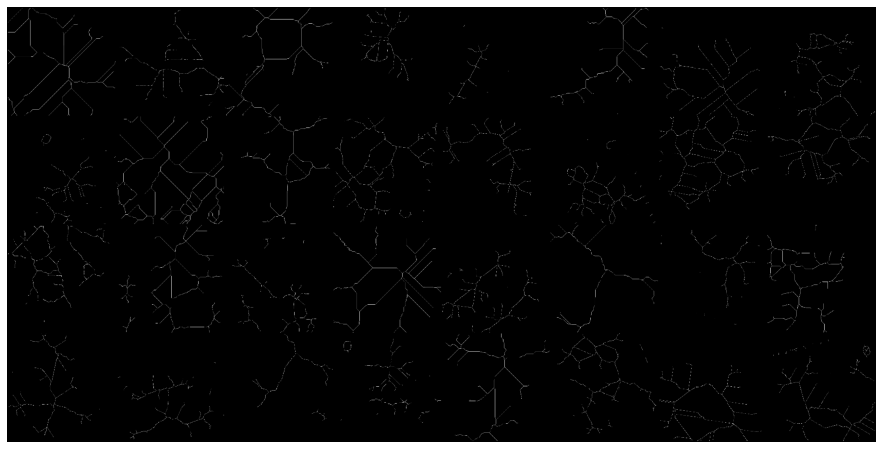

In [28]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

In [29]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.densenet169(pretrained=True)
N_Classes = train_df['category'].nunique()

# for param in model.parameters():
#     param.requires_grad = False
    
n_inputs = model.classifier.in_features
last_layer = nn.Linear(n_inputs, N_Classes)
model.classifier = last_layer

if torch.cuda.is_available():
    model.cuda()   

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [10]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model = torch.load('./edge_dense2.pth')

# if torch.cuda.is_available():
#     model.cuda()   

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters())

In [31]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

from tqdm import tqdm

def train(trainloader, model, criterion, optimizer, scaler, device=torch.device(device)):
    train_acc = 0.0
    train_loss = 0.0
    model.train()
    for images, labels in tqdm(train_dl):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            output = model(images)
            loss = criterion(output, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        acc = ((output.argmax(dim=1) == labels).float().mean())
        train_acc += acc
        train_loss += loss
        del output
        del loss
    return train_acc/len(trainloader), train_loss/len(trainloader)

def evaluate(testloader, model, criterion, device=torch.device(device)):
    eval_acc = 0.0
    eval_loss = 0.0
    model.eval()
    for images, labels in tqdm(val_dl):
        images = images.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            output = model(images)
            loss = criterion(output, labels)

        acc = ((output.argmax(dim=1) == labels).float().mean())
        eval_acc += acc
        eval_loss += loss
        del output
        del loss
  
    return eval_acc/len(testloader), eval_loss/len(testloader)

In [32]:
%%time
##%dirsrmal Training
scaler = torch.cuda.amp.GradScaler(enabled=True)
for epoch in range(EPOCHS):
    train_acc, train_loss = train(train_dl, model, criterion, optimizer, scaler, device=device)
    torch.save(model, './edge_dense.pth')
    eval_acc, eval_loss = evaluate(val_dl, model, criterion, device=device)
    print("")
    print(f"Epoch {epoch + 1} | Train Acc: {train_acc*100} | Train Loss: {train_loss}")
    print(f"\t Val Acc: {eval_acc*100} | Val Loss: {eval_loss}")
    print("===="*8)

100%|██████████| 5/5 [00:24<00:00,  4.85s/it]



Epoch 1 | Train Acc: 14.943181037902832 | Train Loss: 2.210359573364258
	 Val Acc: 9.375 | Val Loss: 2.4424543380737305


100%|██████████| 5/5 [00:23<00:00,  4.79s/it]



Epoch 2 | Train Acc: 16.818180084228516 | Train Loss: 2.1585681438446045
	 Val Acc: 13.75 | Val Loss: 2.7013261318206787


100%|██████████| 5/5 [00:24<00:00,  4.84s/it]



Epoch 3 | Train Acc: 16.988636016845703 | Train Loss: 2.143949031829834
	 Val Acc: 13.125000953674316 | Val Loss: 2.3206899166107178


100%|██████████| 5/5 [00:24<00:00,  4.84s/it]



Epoch 4 | Train Acc: 15.909090995788574 | Train Loss: 2.153435230255127
	 Val Acc: 9.375 | Val Loss: 3.778343677520752


100%|██████████| 5/5 [00:23<00:00,  4.70s/it]



Epoch 5 | Train Acc: 17.386363983154297 | Train Loss: 2.1413919925689697
	 Val Acc: 13.125000953674316 | Val Loss: 2.2301177978515625


 71%|███████   | 39/55 [04:10<01:42,  6.42s/it]


KeyboardInterrupt: 

torch.Size([13, 3, 224, 224])

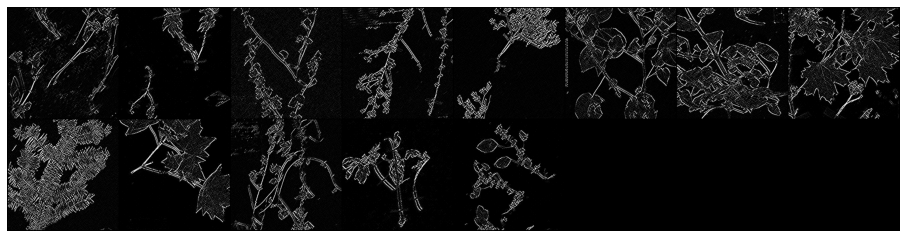

In [56]:
for images, labels in val_dl:
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        output = model(images)
    break

images = images[output.argmax(dim=1) != labels].cpu()

plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
images.shape